In [1]:
import os
import sys

import pandas as pd
import geopandas as gpd
import osmnx as ox
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

module_path = os.path.abspath(os.path.join('../../'))
if module_path not in sys.path:
    sys.path.append(module_path)
    import aup

/usr/local/python/lib/python3.10/site-packages/osmnx/utils.py:192: UserWarning: The `utils.config` function is deprecated and will be removed in a future release. Instead, use the `settings` module directly to configure a global setting's value. For example, `ox.settings.log_console=True`.
  warnings.warn(


In [3]:
save = True
save_space = True

## Required data

### Required data - Area of interest

<Axes: >

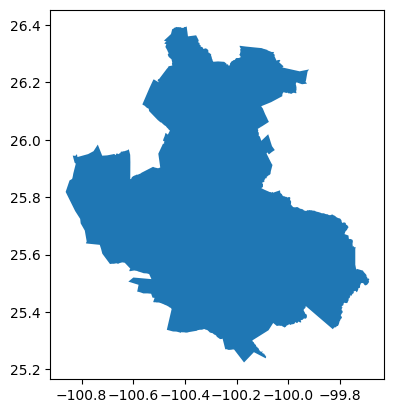

In [2]:
city = 'Monterrey'

# Source Data
schema = 'metropolis'
folder = 'metro_gdf'

# Downloads hexagons within 'city'
query = f"SELECT * FROM {schema}.{folder} WHERE \"city\" LIKE \'{city}\'"
mun_gdf = aup.gdf_from_query(query, geometry_col='geometry')

mun_gdf = mun_gdf.set_crs("EPSG:4326")
aoi = mun_gdf.dissolve()
aoi = aoi[['city','geometry']]

#Show
aoi.plot()

In [4]:
#Save
if save:
    aoi.to_file('../../data/external/prox_latam/aoi_mty.gpkg', driver='GPKG')

### Required data - Points of interest - DENUE

In [4]:
poly_wkt = aoi.dissolve().geometry.to_wkt()[0]

In [5]:
# Creates query to download DENUE from the metropolitan area or capital
query = f"SELECT * FROM denue.denue_2020 WHERE ST_Intersects(geometry, \'SRID=4326;{poly_wkt}\')"
denue = aup.gdf_from_query(query, geometry_col='geometry')

denue = denue[['codigo_act', 'geometry']]

#Show
print(denue.shape)
denue.head(2)

(166633, 2)


,codigo_act,geometry
0,237212.0,POINT (-100.20686 25.67193)
1,237312.0,POINT (-100.19833 25.67555)


In [6]:
# Set denue amenities of interest
denue_sources = {'denue_preescolar':[611111, 611112], 
                 'denue_primaria':[611121, 611122],
                 'denue_secundaria':[611131, 611132], 
                 'denue_guarderias':[624411, 624412],
                 'denue_dif':[931610],
                 'denue_supermercado':[462111],'denue_abarrotes':[461110], 'denue_carnicerias': [461121, 461122, 461123],
                 'denue_peluqueria':[812110],
                 'denue_farmacias':[464111, 464112],
                 'denue_ferreteria_tlapaleria':[467111],'denue_art_limpieza':[467115],
                 'denue_ropa':[463211, 463212, 463213, 463215, 463216, 463218],'denue_calzado':[463310], 'denue_muebles':[466111, 466112, 466113, 466114],'denue_lavanderia':[812210],'denue_revistas_periodicos':[465313],'denue_pintura':[467113],
                 'denue_restaurante_insitu':[722511, 722512, 722513, 722514, 722519],'denue_restaurante_llevar':[722516, 722518, 722517],'denue_bares':[722412],'denue_cafe':[722515],
                 'denue_parque_natural':[712190],
                 'denue_cines':[512130],
                 'denue_centro_cultural':[711311,711312],'denue_biblioteca':[519121,519122],
                 'denue_museos':[712111, 712112]}

# Iterate over denue_amenities and filter denue gdf
denue_pois = gpd.GeoDataFrame()

for s in denue_sources:
    for code in denue_sources[s]:
        denue_tmp = denue.loc[denue['codigo_act'] == code]
        denue_pois = pd.concat([denue_pois,denue_tmp])

# Format
denue_pois = denue_pois.rename(columns={'codigo_act':'code'})
denue_pois['code'] = denue_pois['code'].astype('int64')

# Saves space in disk if instructed
if save_space:
    del denue
    del denue_tmp
        
# Show
print(denue_pois.shape)
denue_pois.head(2)

(61930, 2)


,code,geometry
217,611111,POINT (-100.20505 25.67201)
1246,611111,POINT (-100.32507 25.69189)


### Required data - Points of interest - CLUES

In [7]:
# Creates query to download DENUE from the metropolitan area or capital
query = f"SELECT * FROM denue.clues WHERE ST_Intersects(geometry, \'SRID=4326;{poly_wkt}\')"
clues = aup.gdf_from_query(query, geometry_col='geometry')

# Set and filter CLUES amenities of interest
clues_pois = clues.loc[clues['nivel_atencion'] == 'PRIMER NIVEL']

#Format
clues_pois.loc[:,'code'] = 8610
clues_pois = clues_pois[['code','geometry']]

# Saves space in disk if instructed
if save_space:
    del clues

# Show
print(clues_pois.shape)
clues_pois.head(2)

(878, 2)


/usr/local/python/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


,code,geometry
0,8610,POINT (-100.28076 25.34542)
1,8610,POINT (-100.42010 25.36860)


### Required data - Points of interest - SIP

In [8]:
# Creates query to download DENUE from the metropolitan area or capital
query = f"SELECT * FROM denue.sip_2020 WHERE ST_Intersects(geometry, \'SRID=4326;{poly_wkt}\')"
sip = aup.gdf_from_query(query, geometry_col='geometry')

sip_amenities = {'GEOGRAFICO':['Mercado','Plaza'], 
                 'TIPO':['Cancha','Unidad Deportiva','Áreas Verdes','Jardín','Parque']}

sip_amenities_codes = {
    #sip_mercado
    'Mercado':4721,
    #sip_cancha                   
    'Cancha':93110,
    #sip_unidad_deportiva                   
    'Unidad Deportiva':93111,
    #sip_espacio_publico
    'Áreas Verdes':9321,    
    'Jardín':9321,    
    'Parque':9321, 
    'Plaza':9321}    
    
# Iterate over sip_amenities and filter sip gdf
sip_pois = gpd.GeoDataFrame()

for col in sip_amenities:
    for amenity in sip_amenities[col]:
        sip_tmp = sip.loc[sip[col] == amenity]
        sip_tmp.loc[:,'code'] = sip_amenities_codes[amenity]
        sip_pois = pd.concat([sip_pois,sip_tmp])

#Format
sip_pois = sip_pois[['code','geometry']]

# Saves space in disk if instructed
if save_space:
    del sip

# Show
print(sip_pois.shape)
sip_pois.head(2)

(5070, 2)


/usr/local/python/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/usr/local/python/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/usr/local/python/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,

,code,geometry
1797,4721,POINT (-100.31708 25.68795)
2118,4721,POINT (-100.31852 25.66898)


In [9]:
pois = pd.concat([denue_pois,clues_pois,sip_pois])

# Saves space in disk if instructed
if save_space:
    del denue_pois
    del clues_pois
    del sip_pois

# Show
print(pois.shape)
pois.head(2)

(67878, 2)


,code,geometry
217,611111,POINT (-100.20505 25.67201)
1246,611111,POINT (-100.32507 25.69189)


In [10]:
#Save
if save:
    pois.to_file('../../data/external/prox_latam/pois_cultural_mty.gpkg', driver='GPKG')

### Required data - Pop data

In [12]:
# Get CVEGEO list from Municipality
cve_geo_lst = mun_gdf.CVEGEO.unique()

# Query from CVEGEO list
schema = 'censo_mza'
table = 'censo_mza_2020'

pop_gdf = gpd.GeoDataFrame()

for i in range(len(cve_geo_lst)):
    m = cve_geo_lst[i]
    query = f"SELECT * FROM {schema}.{table} WHERE \"CVEGEO\" LIKE \'{m}%%\'"
    pop_gdf = pop_gdf.append(aup.gdf_from_query(query, geometry_col='geometry'))
    
#---------------------------------------------------------------------------------------------------------------------------------------------------------
print(f"Downloaded pop data for aoi.")
#---------------------------------------------------------------------------------------------------------------------------------------------------------

#Show
print(pop_gdf.shape)
pop_gdf.head(2)

Exception during reset or similar
Traceback (most recent call last):
  File "/usr/local/python/lib/python3.10/site-packages/sqlalchemy/pool/base.py", line 991, in _finalize_fairy
    fairy._reset(
  File "/usr/local/python/lib/python3.10/site-packages/sqlalchemy/pool/base.py", line 1440, in _reset
    pool._dialect.do_rollback(self)
  File "/usr/local/python/lib/python3.10/site-packages/sqlalchemy/engine/default.py", line 657, in do_rollback
    dbapi_connection.rollback()
psycopg2.OperationalError: SSL SYSCALL error: EOF detected

Exception during reset or similar
Traceback (most recent call last):
  File "/usr/local/python/lib/python3.10/site-packages/sqlalchemy/pool/base.py", line 991, in _finalize_fairy
    fairy._reset(
  File "/usr/local/python/lib/python3.10/site-packages/sqlalchemy/pool/base.py", line 1440, in _reset
    pool._dialect.do_rollback(self)
  File "/usr/local/python/lib/python3.10/site-packages/sqlalchemy/engine/default.py", line 657, in do_rollback
    dbapi_connec

Downloaded pop data for aoi.
(64727, 239)


,CVEGEO,CVE_ENT,CVE_MUN,CVE_LOC,CVE_AGEB,CVE_MZA,AMBITO,TIPOMZA,geometry,ENTIDAD,...,VPH_TELEF,VPH_CEL,VPH_INTER,VPH_STVP,VPH_SPMVPI,VPH_CVJ,VPH_SINRTV,VPH_SINLTC,VPH_SINCINT,VPH_SINTIC
0,1900100010055001,19,001,0001,0055,001,Urbana,Típica,"POLYGON ((-100.38820 25.94035, -100.38939 25.9...",19,...,None,None,None,None,None,None,None,None,None,None
1,1900100010021004,19,001,0001,0021,004,Urbana,Típica,"POLYGON ((-100.40140 25.94833, -100.40127 25.9...",19,...,None,7,4,3,4,3,0,0,3,0


In [13]:
#Save
if save:
    pop_gdf.to_file('../../data/external/prox_latam/pop_gdf_mty.gpkg', driver='GPKG')